In [1]:
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.cross_validation import KFold

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

full_data = [train, test]
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [4]:
# Some features of my own that I have added in
# Gives the length of the name
train['Name_length'] = train['Name'].apply(len)
test['Name_length'] = test['Name'].apply(len)
# Feature that tells whether a passenger had a cabin on the Titanic
train['Has_Cabin'] = train["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test['Has_Cabin'] = test["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
# Create new feature IsAlone from FamilySize
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
# Remove all NULLS in the Embarked column
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
# Remove all NULLS in the Fare column and create a new feature CategoricalFare
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
# Create a New feature CategoricalAge
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
train['CategoricalAge'] = pd.cut(train['Age'], 5)
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in full_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)
    
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    # Mapping Fare
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
    # Mapping Age
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4 ;

In [5]:
ids = test['PassengerId']
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train = train.drop(drop_elements, axis = 1)
train = train.drop(['CategoricalAge', 'CategoricalFare'], axis = 1)
test  = test.drop(drop_elements, axis = 1)

In [6]:
train.head(3)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,0,3,1,1,0,0,0,23,0,2,0,1
1,1,1,0,2,0,3,1,51,1,2,0,3
2,1,3,0,1,0,1,0,22,0,1,1,2


In [7]:
test.head(3)

,Pclass,Sex,Age,Parch,Fare,Embarked,Name_length,Has_Cabin,FamilySize,IsAlone,Title
0,3,1,2,0,0,2,16,0,1,1,1
1,3,0,2,0,0,0,32,0,2,0,3
2,2,1,3,0,1,2,25,0,1,1,1


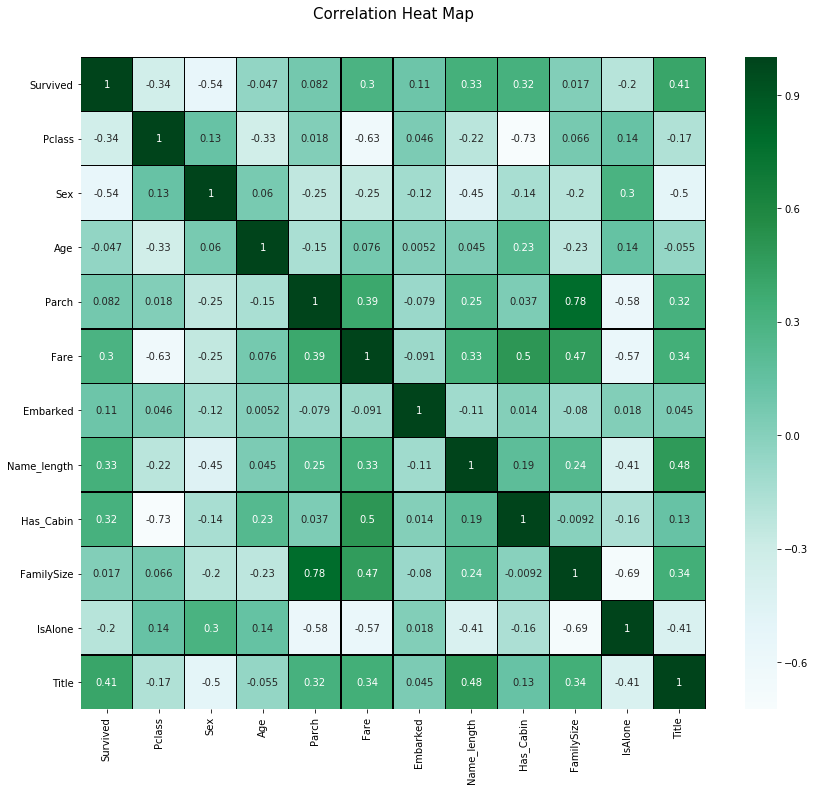

In [8]:
colormap = plt.cm.BuGn
plt.figure(figsize=(14,12))
plt.title('Correlation Heat Map', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(), linewidths=0.2, cmap=colormap, linecolor = 'black', annot=True)

In [9]:
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [10]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#test model accuracy on training/test data made from training data
# X, y = train.iloc[:, 1:], train.iloc[:, 0]

# X_train, X_test, y_train, y_test =\
#        train_test_split(X, y, 
#                         test_size=0.5, 
#                         random_state=1,
#                         stratify=y)

X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test

In [11]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

# print('10-fold cross validation:\n')
# for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
#     scores = cross_val_score(estimator=clf,
#                              X=X_train,
#                              y=y_train,
#                              cv=10,
#                              scoring='roc_auc')
#     print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
#           % (scores.mean(), scores.std(), label))

In [12]:
# Majority Rule Voting

mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])

clf_labels += ['Majority voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.84 (+/- 0.04) [Logistic regression]
ROC AUC: 0.78 (+/- 0.04) [Decision tree]
ROC AUC: 0.75 (+/- 0.05) [KNN]
ROC AUC: 0.84 (+/- 0.04) [Majority voting]


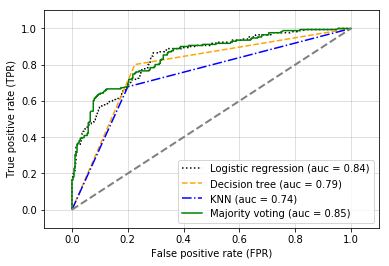

In [121]:
# from sklearn.metrics import roc_curve
# from sklearn.metrics import auc

# colors = ['black', 'orange', 'blue', 'green']
# linestyles = [':', '--', '-.', '-']
# for clf, label, clr, ls \
#         in zip(all_clf,
#                clf_labels, colors, linestyles):

#     # assuming the label of the positive class is 1
#     y_pred = clf.fit(X_train,
#                      y_train).predict_proba(X_test)[:, 1]
#     fpr, tpr, thresholds = roc_curve(y_true=y_test,
#                                      y_score=y_pred)
#     roc_auc = auc(x=fpr, y=tpr)
#     plt.plot(fpr, tpr,
#              color=clr,
#              linestyle=ls,
#              label='%s (auc = %0.2f)' % (label, roc_auc))

# plt.legend(loc='lower right')
# plt.plot([0, 1], [0, 1],
#          linestyle='--',
#          color='gray',
#          linewidth=2)

# plt.xlim([-0.1, 1.1])
# plt.ylim([-0.1, 1.1])
# plt.grid(alpha=0.5)
# plt.xlabel('False positive rate (FPR)')
# plt.ylabel('True positive rate (TPR)')


# #plt.savefig('images/07_04', dpi=300)
# plt.show()

In [13]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
#X_test_std = sc.fit_transform(X_test)

In [14]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 

In [15]:
from sklearn.model_selection import GridSearchCV

params = {'decisiontreeclassifier__max_depth': [3, 8, 15],
          'pipeline-1__clf__C': [0.001, 0.1, 100.0]}

grid = GridSearchCV(estimator=mv_clf,
                    param_grid=params,
                    cv=10,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

for r, _ in enumerate(grid.cv_results_['mean_test_score']):
    print("%0.3f +/- %0.2f %r"
          % (grid.cv_results_['mean_test_score'][r], 
             grid.cv_results_['std_test_score'][r] / 2.0, 
             grid.cv_results_['params'][r]))

0.855 +/- 0.02 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.001}
0.864 +/- 0.02 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.1}
0.863 +/- 0.02 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 100.0}
0.851 +/- 0.02 {'decisiontreeclassifier__max_depth': 8, 'pipeline-1__clf__C': 0.001}
0.861 +/- 0.02 {'decisiontreeclassifier__max_depth': 8, 'pipeline-1__clf__C': 0.1}
0.860 +/- 0.02 {'decisiontreeclassifier__max_depth': 8, 'pipeline-1__clf__C': 100.0}
0.837 +/- 0.02 {'decisiontreeclassifier__max_depth': 15, 'pipeline-1__clf__C': 0.001}
0.853 +/- 0.02 {'decisiontreeclassifier__max_depth': 15, 'pipeline-1__clf__C': 0.1}
0.853 +/- 0.02 {'decisiontreeclassifier__max_depth': 15, 'pipeline-1__clf__C': 100.0}


In [16]:
print('Best parameters: %s' % grid.best_params_)
print('Accuracy: %.2f' % grid.best_score_)

Best parameters: {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.1}
Accuracy: 0.86


In [17]:
grid.best_estimator_.classifiers

[Pipeline(memory=None,
      steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False)]]),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 Pipeline(memory=None,
      steps=[['sc', StandardScaler(copy=True, with_mean=True, with_std=True)], ['clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=1, p=2,
            weights='u

In [18]:
mv_clf = grid.best_estimator_

In [19]:
mv_clf.set_params(**grid.best_estimator_.get_params())

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', rand...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None)

In [20]:
mv_clf

MajorityVoteClassifier(classifiers=[Pipeline(memory=None,
     steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', rand...ski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform'))])],
            vote='classlabel', weights=None)

In [21]:
for params, mean_score, scores in grid.grid_scores_:
    print("%0.3f+/-%0.2f %r"
    % (mean_score, scores.std() / 2, params))

0.855+/-0.02 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.001}
0.864+/-0.02 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.1}
0.863+/-0.02 {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 100.0}
0.851+/-0.02 {'decisiontreeclassifier__max_depth': 8, 'pipeline-1__clf__C': 0.001}
0.861+/-0.02 {'decisiontreeclassifier__max_depth': 8, 'pipeline-1__clf__C': 0.1}
0.860+/-0.02 {'decisiontreeclassifier__max_depth': 8, 'pipeline-1__clf__C': 100.0}
0.837+/-0.02 {'decisiontreeclassifier__max_depth': 15, 'pipeline-1__clf__C': 0.001}
0.853+/-0.02 {'decisiontreeclassifier__max_depth': 15, 'pipeline-1__clf__C': 0.1}
0.853+/-0.02 {'decisiontreeclassifier__max_depth': 15, 'pipeline-1__clf__C': 100.0}


In [22]:
print('Best parameters: %s' % grid.best_params_)

Best parameters: {'decisiontreeclassifier__max_depth': 3, 'pipeline-1__clf__C': 0.1}


In [258]:
 print('Accuracy: %.2f' % grid.best_score_)

Accuracy: 0.87


In [23]:
pred = list(mv_clf.predict(X_test))

In [24]:
pred_dict = dict(zip(ids, pred))
sub = pd.DataFrame.from_dict(pred_dict, orient='index')
sub.reset_index(inplace=True)
sub.columns = ['PassengerId', 'Survived']
sub.to_csv('Prediction2.csv', index=False)
sub

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
5,897,0
6,898,1
7,899,0
8,900,1
9,901,0
